# Explore here

Accuracy: 0.7486033519553073
ROC AUC Score: 0.8024446142093201
F1 Score: 0.6131805157593124
Precision: 0.6604938271604939
Recall: 0.5721925133689839
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       350
           1       0.66      0.57      0.61       187

    accuracy                           0.75       537
   macro avg       0.72      0.71      0.71       537
weighted avg       0.74      0.75      0.74       537

[[295  55]
 [ 80 107]]
Best Accuracy: 0.7616387337057728
Best ROC AUC Score: 0.8140870893812071
Best F1 Score: 0.6404494382022471
Best Precision: 0.6745562130177515
Best Recall: 0.6096256684491979
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       350
           1       0.67      0.61      0.64       187

    accuracy                           0.76       537
   macro avg       0.74      0.73      0.73       537
weighted avg       0.76      0.76      0.76       537



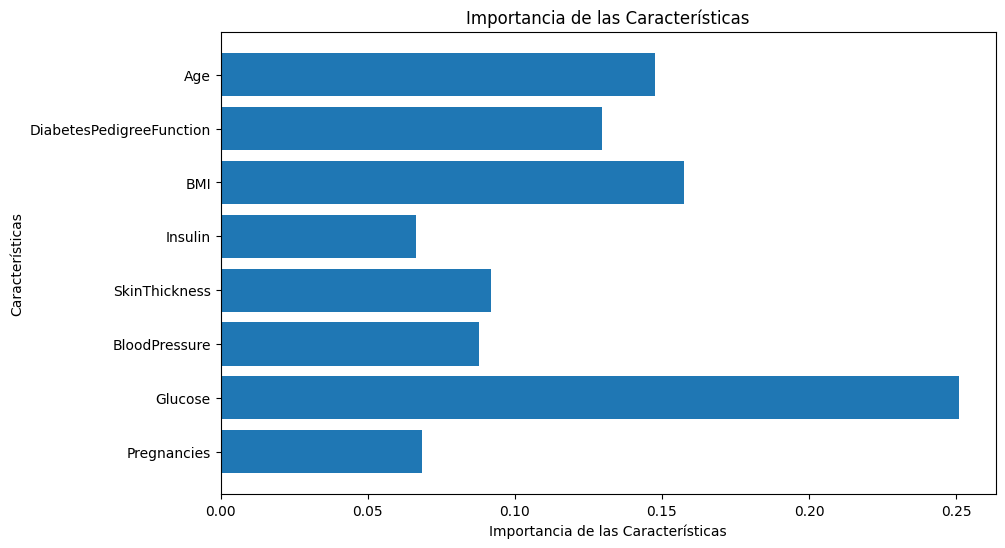

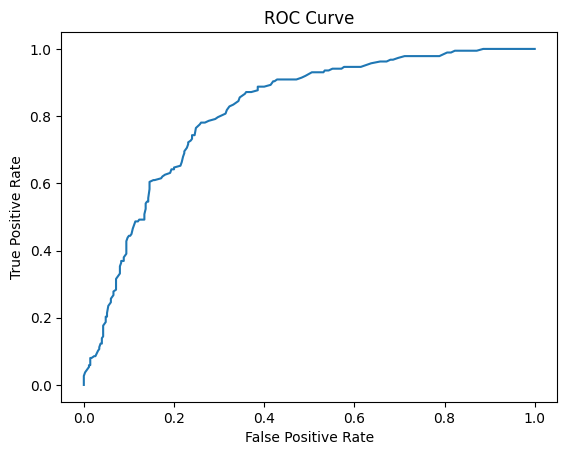

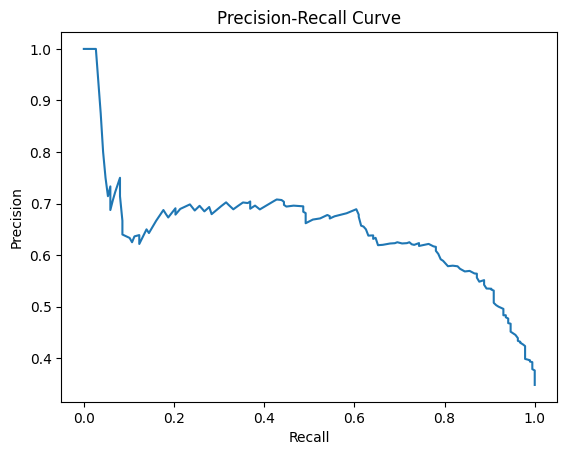

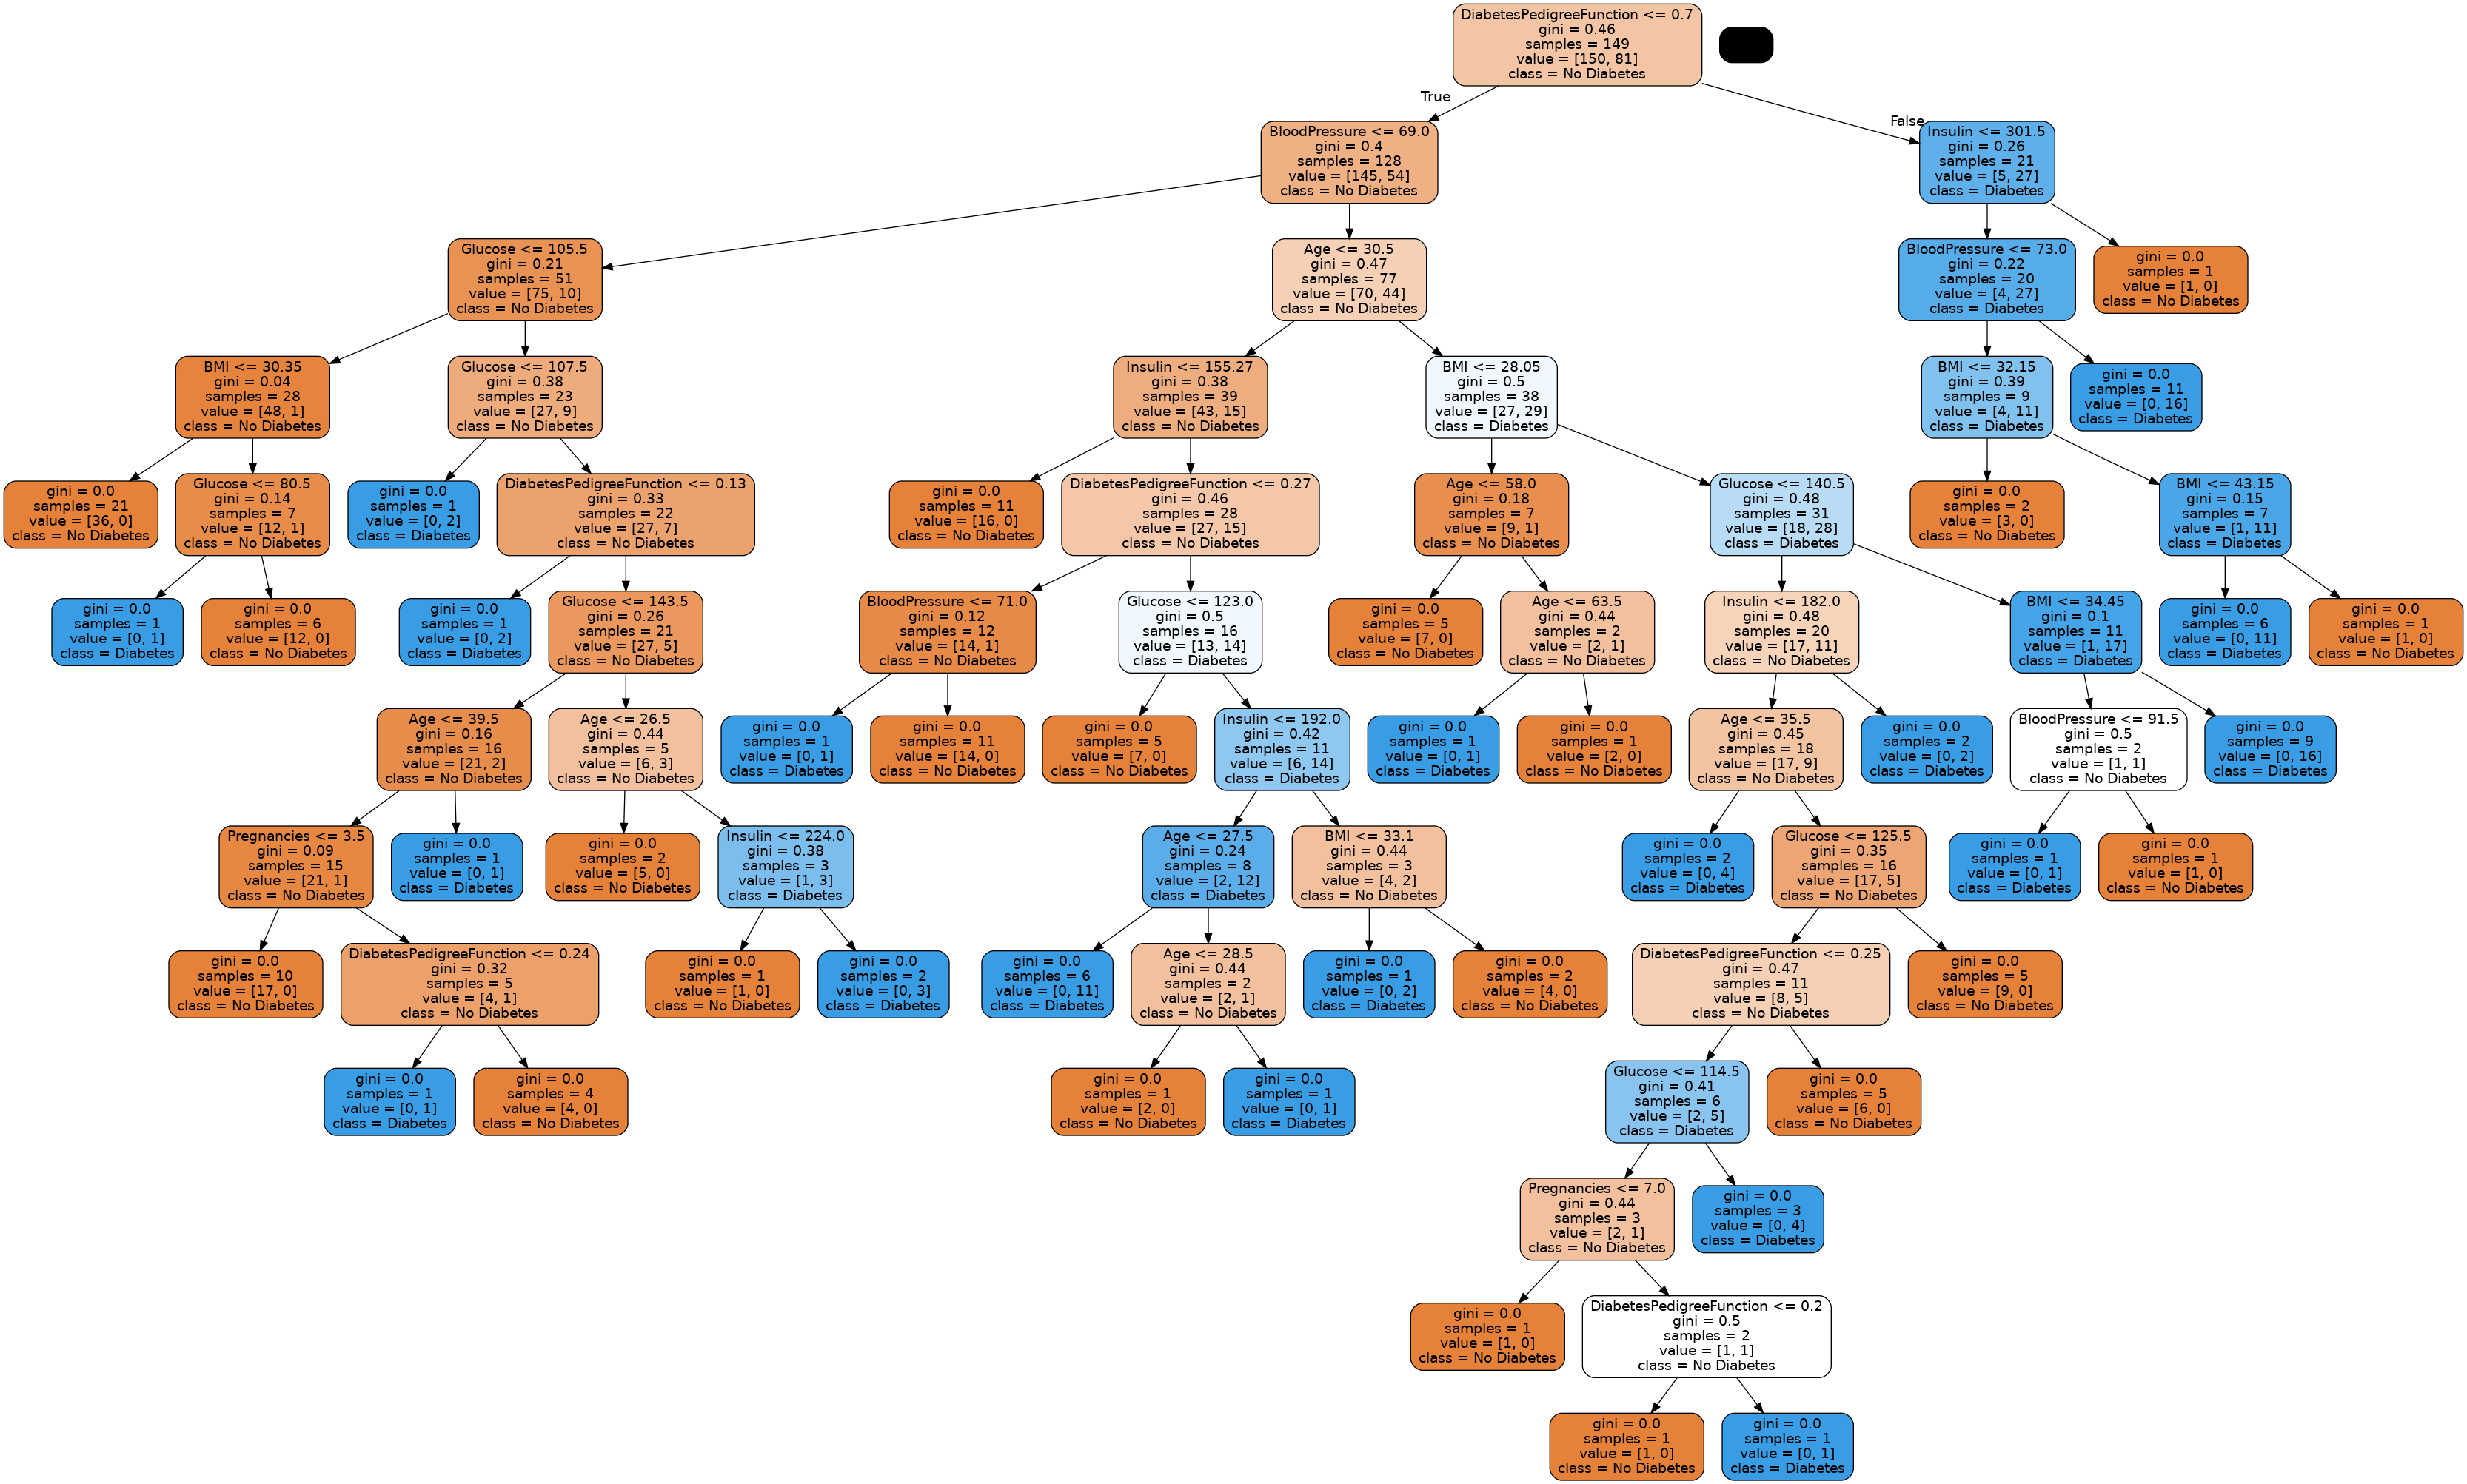

In [3]:
# Importar librerías necesarias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, f1_score, precision_score, recall_score, 
    roc_curve, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import joblib
import graphviz
import pydotplus
from IPython.display import Image

# Crear directorios si no existen
os.makedirs('data/processed', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Verificar la existencia de archivos
train_file = 'data/processed/clean_train.csv'
test_file = 'data/processed/clean_test.csv'

# Levantar una excepción si los archivos no existen
missing_files = []
if not os.path.exists(train_file):
    missing_files.append(train_file)
if not os.path.exists(test_file):
    missing_files.append(test_file)

if missing_files:
    raise FileNotFoundError(f"No se encontraron los archivos de datos necesarios: {', '.join(missing_files)}")

# Cargar datos procesados
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Separar características y la variable objetivo
X_train = train_data.drop('Outcome', axis=1)
y_train = train_data['Outcome']
X_test = test_data.drop('Outcome', axis=1)
y_test = test_data['Outcome']

# Construir el modelo de Random Forest
clf_rf = RandomForestClassifier(random_state=42, n_estimators=60)
clf_rf.fit(X_train, y_train)

# Evaluar el modelo
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_proba = clf_rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf_proba))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

# Guardar el modelo
joblib.dump(clf_rf, 'models/random_forest_model.pkl')

# Optimización del Modelo
# Definir los parámetros a optimizar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_rf = grid_search.best_estimator_

# Evaluar el mejor modelo
y_pred_best_rf = best_rf.predict(X_test)
y_pred_best_rf_proba = best_rf.predict_proba(X_test)[:, 1]
print("Best Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Best ROC AUC Score:", roc_auc_score(y_test, y_pred_best_rf_proba))
print("Best F1 Score:", f1_score(y_test, y_pred_best_rf))
print("Best Precision:", precision_score(y_test, y_pred_best_rf))
print("Best Recall:", recall_score(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))

# Guardar el modelo optimizado
joblib.dump(best_rf, 'models/best_random_forest_model.pkl')

# Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, best_rf.feature_importances_)
plt.xlabel('Importancia de las Características')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.savefig('feature_importances.png')
plt.show()

# Visualización de las curvas ROC y de Precisión-Recall
fpr, tpr, _ = roc_curve(y_test, y_pred_best_rf_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('roc_curve.png')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_best_rf_proba)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig('precision_recall_curve.png')
plt.show()

# Visualización de un árbol del Random Forest
# Seleccionamos el primer árbol del bosque
estimator = best_rf.estimators_[0]

# Exportar el árbol a un archivo dot
export_graphviz(estimator, out_file='tree.dot', 
                feature_names=X_train.columns,
                class_names=['No Diabetes', 'Diabetes'],
                rounded=True, proportion=False, 
                precision=2, filled=True)

# Usar pydotplus para convertir el archivo dot a un formato gráfico
with open("tree.dot") as f:
    dot_graph = f.read()
graph = pydotplus.graph_from_dot_data(dot_graph)
graph.write_png("tree.png")

# Mostrar el árbol
Image(filename = "tree.png")